In [1]:
%matplotlib inline

In [2]:
from scipy import stats as st
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings('ignore')

sns.set_context("poster")

In [72]:
train = pd.read_csv('data/train_sample.csv').drop('is_booking',1)

##add explicit event_id to merge on - ordering should be the same but better not take the risk
train['event_id'] = [x for x in xrange(len(train))]

train[['event_id','hotel_cluster']].to_csv('data/train_sample_y.csv',index=False)
train.drop('hotel_cluster',1,inplace=True)
train.to_csv('data/train_sample_x.csv',index=False)

In [73]:
train_x = pd.read_csv('data/train_sample_x.csv')
train_x.columns

Index([u'date_time', u'site_name', u'posa_continent', u'user_location_country',
       u'user_location_region', u'user_location_city',
       u'orig_destination_distance', u'user_id', u'is_mobile', u'is_package',
       u'channel', u'srch_ci', u'srch_co', u'srch_adults_cnt',
       u'srch_children_cnt', u'srch_rm_cnt', u'srch_destination_id',
       u'srch_destination_type_id', u'cnt', u'hotel_continent',
       u'hotel_country', u'hotel_market', u'event_id'],
      dtype='object')

What do we want to check?
- data type
- no. uniques
- null values

In [74]:
def desc_df(dataf):
    lentrain = len(dataf)
    outp = []
    for i, j in train_x.dtypes.iteritems():
        outp.append([i, j, float(len(dataf[i].dropna()))/lentrain, len(dataf[i].unique())])

    return pd.DataFrame(outp,columns = ['variable','type','% non null','unique values'])

In [75]:
outp = desc_df(train_x)
outp

,variable,type,% non null,unique values
0,date_time,object,1.000000,149744
1,site_name,int64,1.000000,42
2,posa_continent,int64,1.000000,5
3,user_location_country,int64,1.000000,205
4,user_location_region,int64,1.000000,798
5,user_location_city,int64,1.000000,12983
6,orig_destination_distance,float64,0.662887,94701
7,user_id,int64,1.000000,122308
8,is_mobile,int64,1.000000,2
9,is_package,int64,1.000000,2


### Visualising integer variables

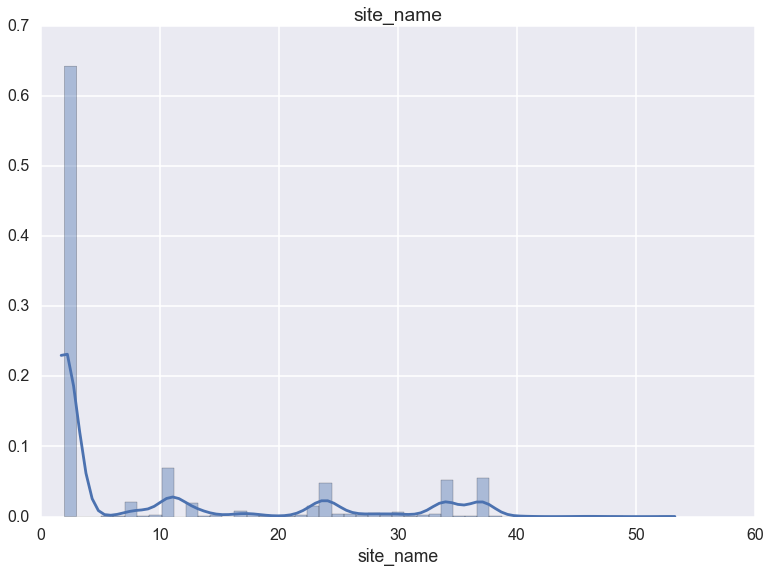

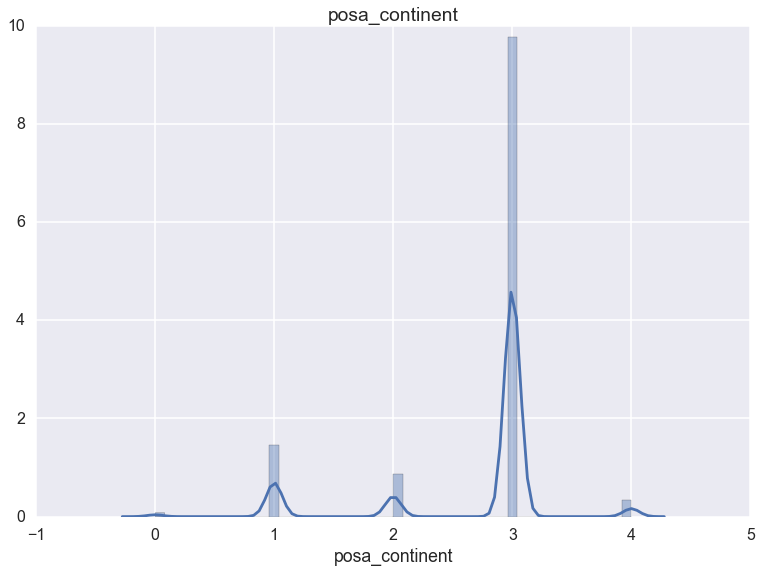

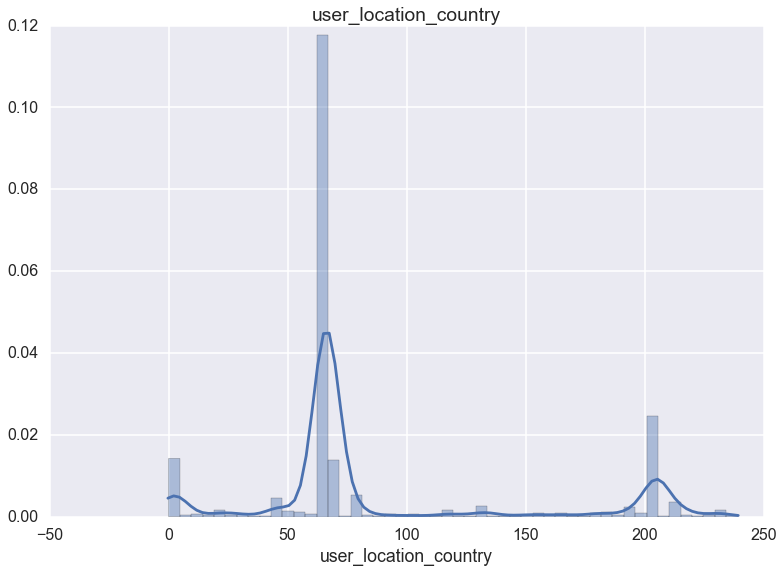

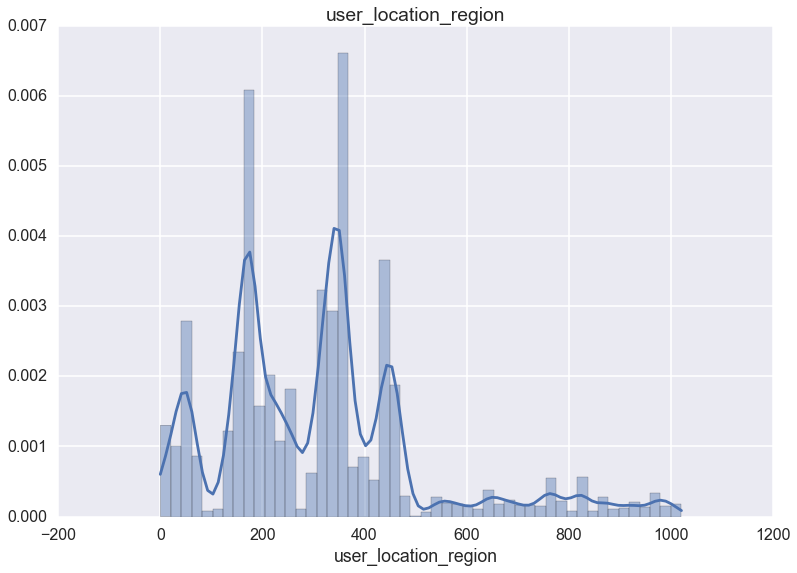

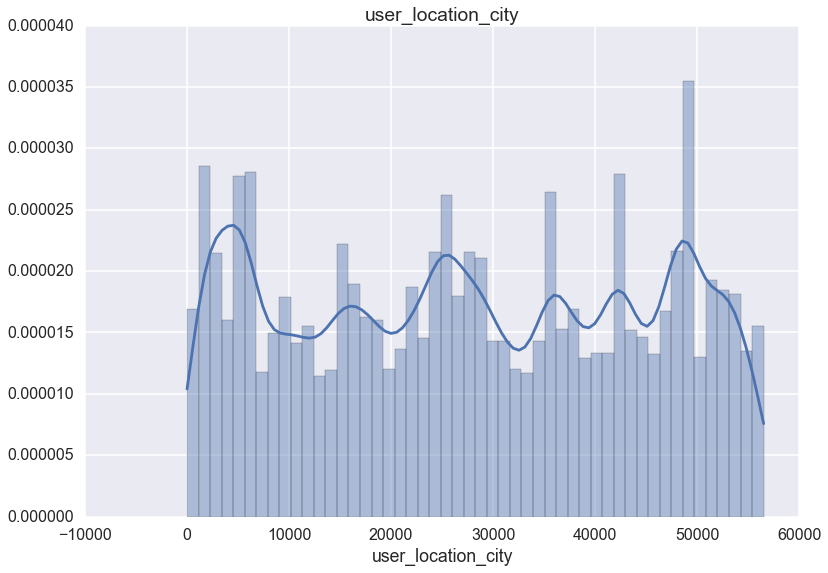

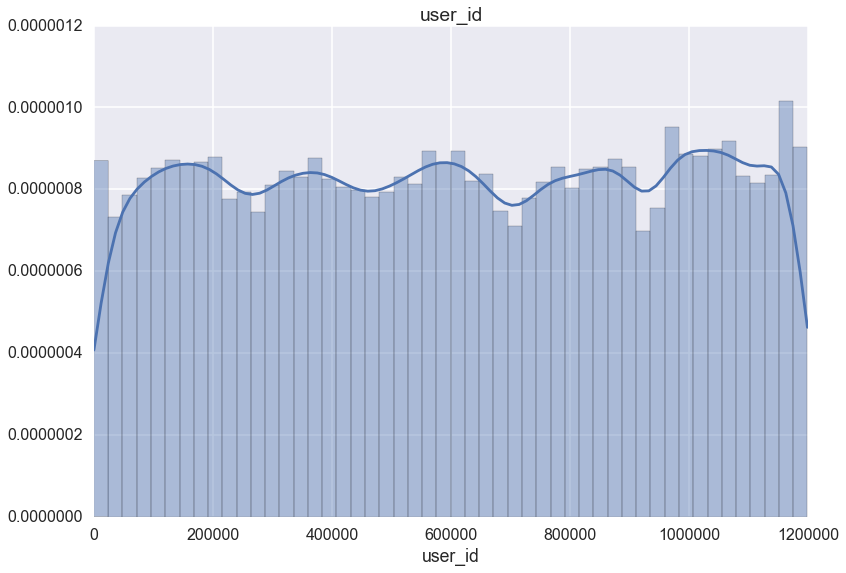

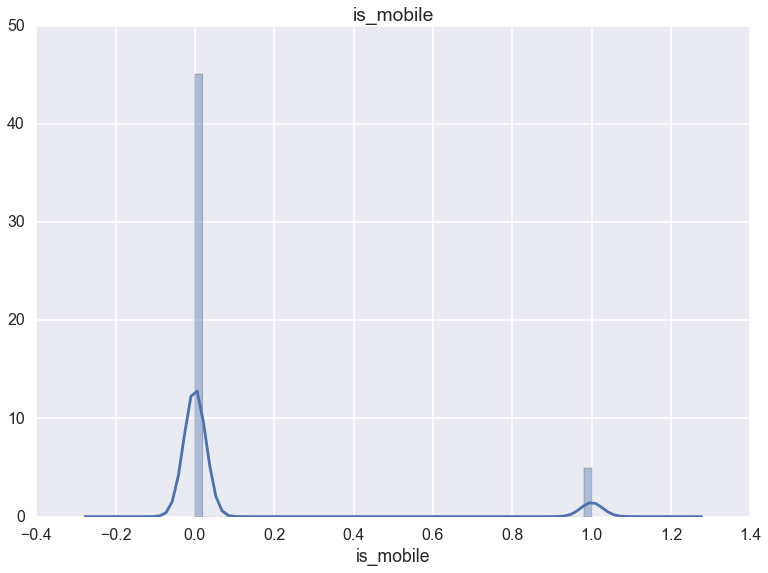

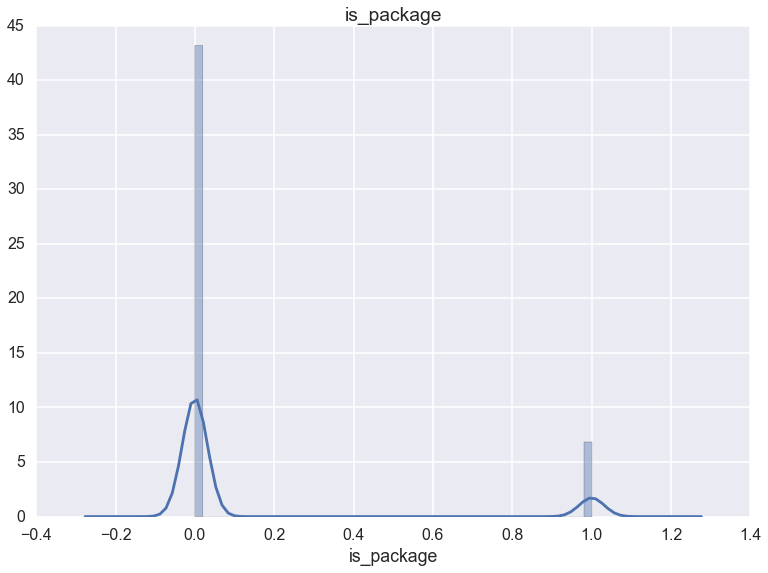

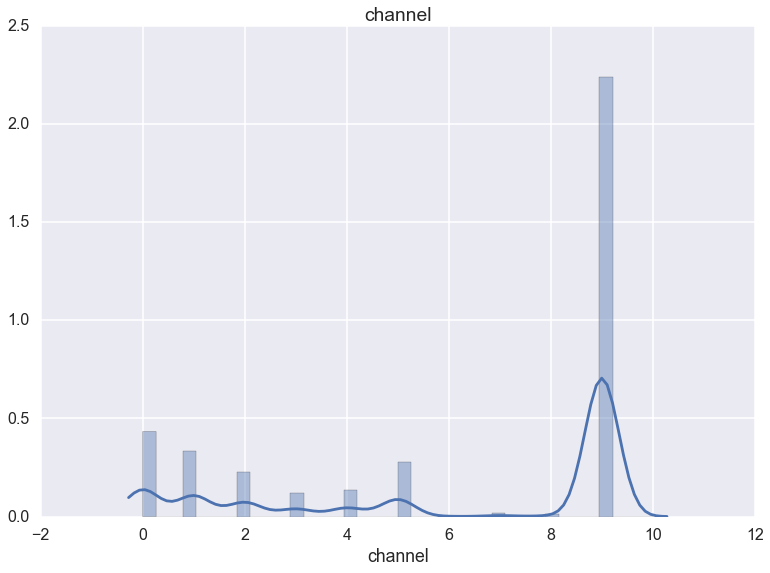

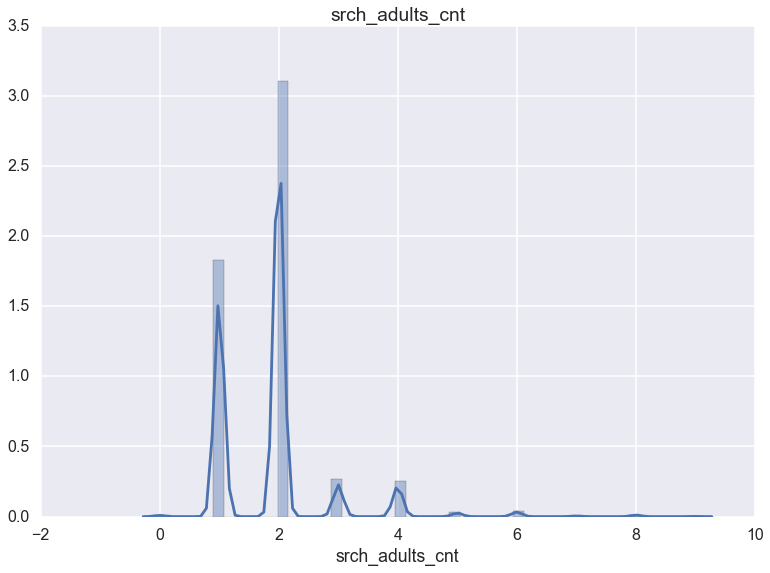

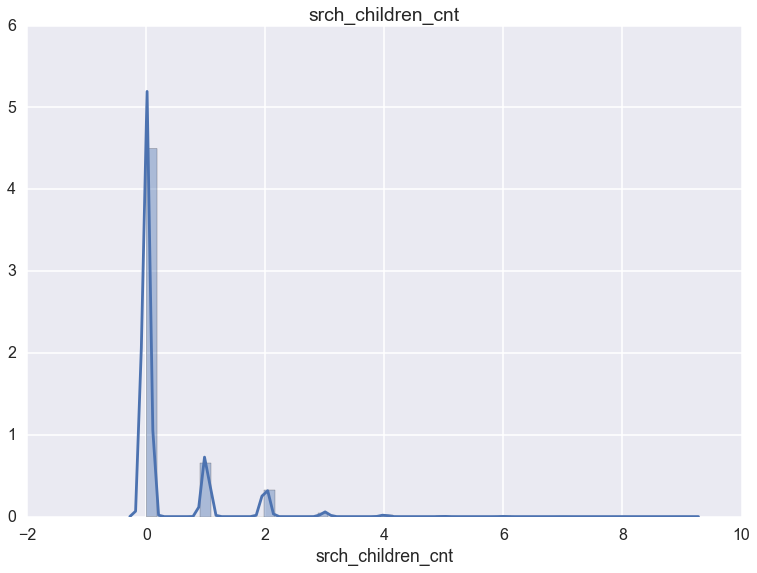

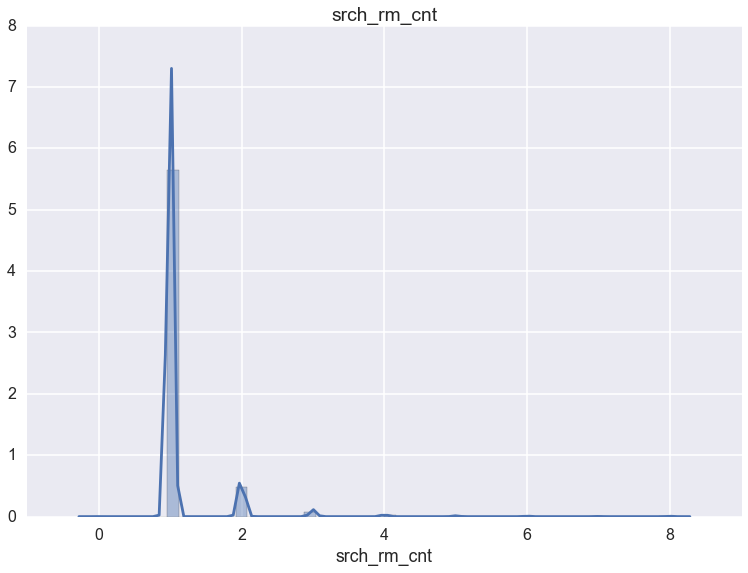

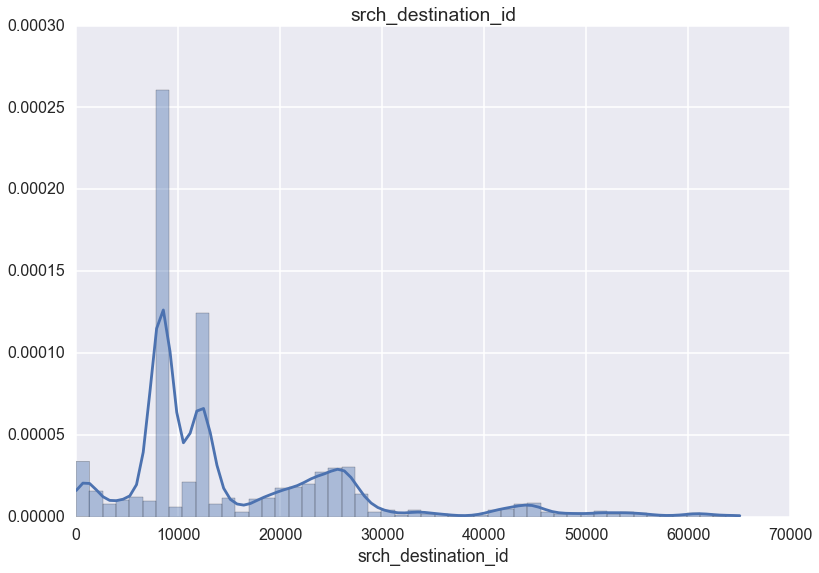

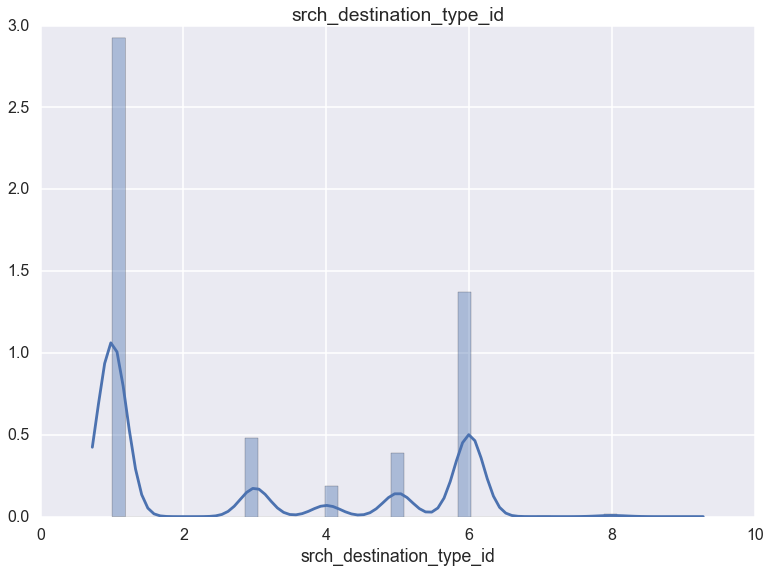

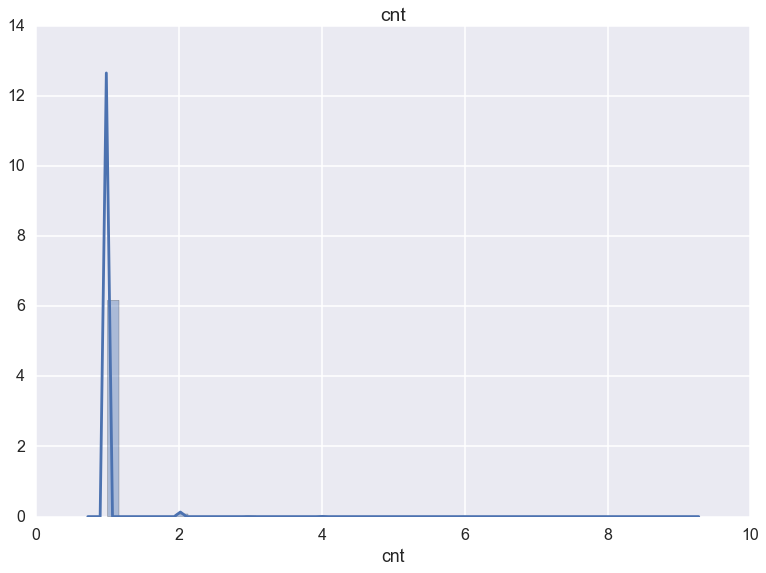

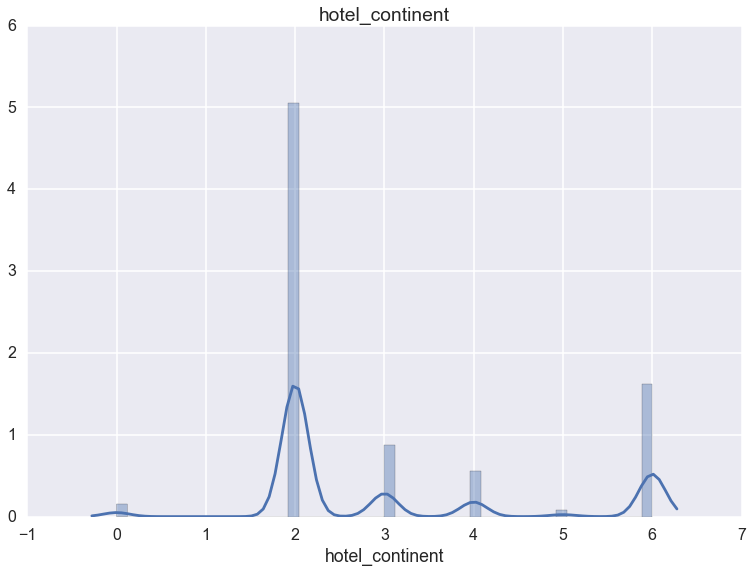

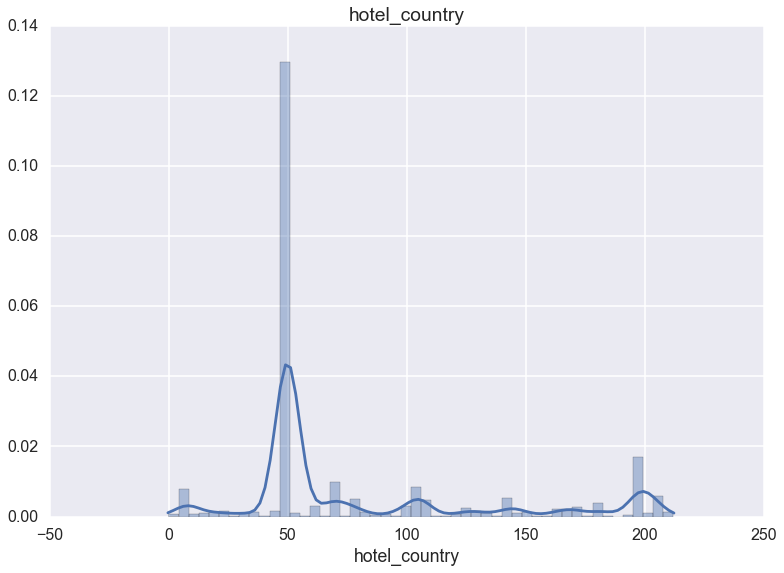

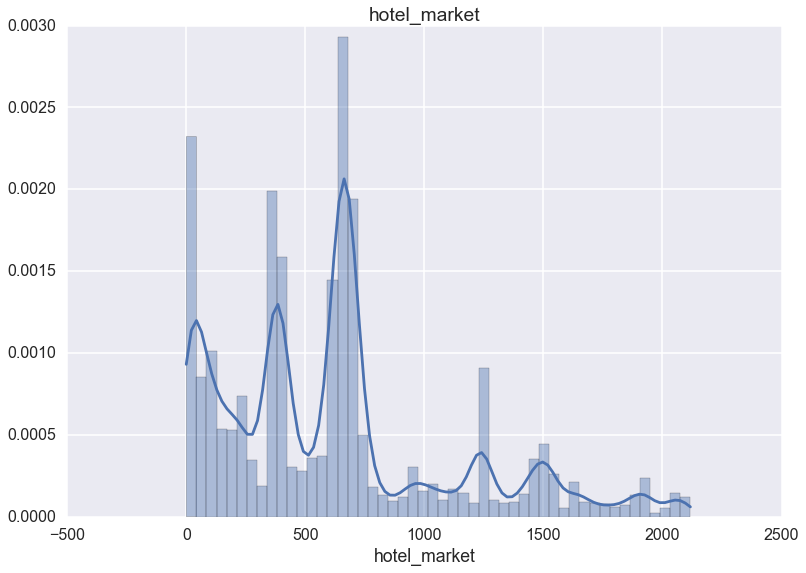

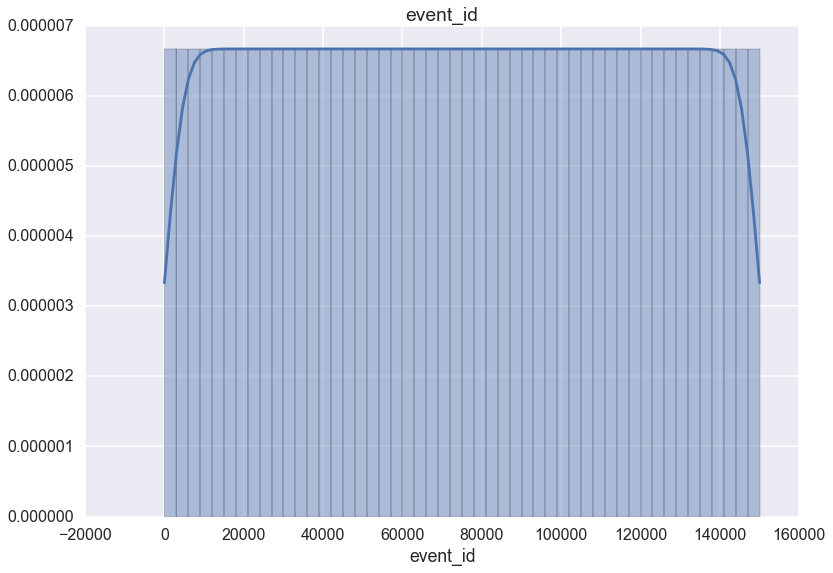

In [76]:
for col in outp[outp['type']=='int64']['variable']:
    sns.distplot(train_x[col])
    plt.title(col)
    plt.show()

In [78]:
train_x[['date_time','srch_ci','srch_co','orig_destination_distance']].head()

,date_time,srch_ci,srch_co,orig_destination_distance
0,2013-12-17 10:48:40,2013-12-25,2013-12-26,723.6547
1,2013-01-23 09:13:38,2013-01-27,2013-01-28,NaN
2,2014-06-25 12:32:13,2014-11-03,2014-11-05,2334.9497
3,2014-05-31 07:22:47,2014-06-02,2014-06-04,503.3213
4,2014-06-30 21:02:08,2014-07-29,2014-07-30,NaN


Looks like for the data manipulation we need to:

* binarize the 'int64' variables
* Create new date variables for the date_times (this will also deal with any null values)
* Keep orig_destination_distance and cnt as is - need to deal with null values
    * Potentially we create bands and all 0's in band deals with null values

In [79]:
def manip(x):
    if x['unique values'] == 2:
        return 'bool'
    if x['variable'] in ['user_id','srch_destination_id','event_id']:
        return 'id'
    if x['type'] == 'int64' and x['variable'] != 'cnt':
        return 'cat'
    if x['variable'] in ['cnt','orig_destination_distance']:
        return 'con'
    if x['variable'] == 'date_time':
        return 'datetime'
    if x['variable'] in ['srch_ci','srch_co']:
        return 'date'

outp['manip_type'] = outp.apply(lambda x: manip(x),1)

In [80]:
outp

,variable,type,% non null,unique values,manip_type
0,date_time,object,1.000000,149744,datetime
1,site_name,int64,1.000000,42,cat
2,posa_continent,int64,1.000000,5,cat
3,user_location_country,int64,1.000000,205,cat
4,user_location_region,int64,1.000000,798,cat
5,user_location_city,int64,1.000000,12983,cat
6,orig_destination_distance,float64,0.662887,94701,con
7,user_id,int64,1.000000,122308,id
8,is_mobile,int64,1.000000,2,bool
9,is_package,int64,1.000000,2,bool


### Data manipulation - Creating the final dataset

I need a function that takes each categorization and does something to the data
* cat - binarise the data
* con - as is
* bool - as is
* date - take out date parts and binarize
* datetime - as above with more date parts

Lets build some binarize function to help us - keeping it in pandas rather than using base sklearn

Now lets look at the dates to create categorical variables and then binarise everything together

For dates we want:

* day
* week of year
* day of week
* month
* year

For datetimes we additinally want:

* hour
* am/pm

First lets deal with destinations.csv - can we make 150 down to a few vars?
---

In [81]:
dest = pd.read_csv('data/destinations.csv')

dest_id = dest['srch_destination_id']
dest_var = dest[['d'+str(x) for x in xrange(1,150)]]

In [82]:
dest_var.head()

,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,-2.198657,...,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,-2.181690,...,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,-2.224164,...,-2.224164,-2.224164,-2.196379,-2.224164,-2.192009,-2.224164,-2.224164,-2.224164,-2.224164,-2.057548
3,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.115485,-2.177409,-2.177409,-2.177409,-2.177409,...,-2.161081,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409
4,-2.189562,-2.187783,-2.194008,-2.171153,-2.152303,-2.056618,-2.194008,-2.194008,-2.145911,-2.194008,...,-2.187356,-2.194008,-2.191779,-2.194008,-2.194008,-2.185161,-2.194008,-2.194008,-2.194008,-2.188037


In [83]:
from sklearn import decomposition

In [84]:
## Lets go with 20 variables - that will be more than enough but we can check the variance
pca = decomposition.PCA(n_components=20)
comps = pca.fit(dest_var)
comps.explained_variance_ratio_

array([ 0.46106252,  0.10834396,  0.04631931,  0.02508247,  0.02338353,
        0.02127211,  0.01691692,  0.01515162,  0.01439368,  0.0123881 ,
        0.01155999,  0.01113869,  0.01036818,  0.00953666,  0.00930158,
        0.0078185 ,  0.00770881,  0.00732783,  0.00672348,  0.00624169])

In [92]:
zip(comps.explained_variance_ratio_.tolist(),pd.Series(comps.explained_variance_ratio_.tolist()).cumsum().tolist())

[(0.461062517389678, 0.46106251738967802),
 (0.10834395687133201, 0.56940647426100999),
 (0.04631930636439759, 0.61572578062540761),
 (0.02508246778221609, 0.64080824840762374),
 (0.023383527154129134, 0.66419177556175291),
 (0.021272110404150866, 0.6854638859659038),
 (0.016916916266457405, 0.70238080223236121),
 (0.015151616704519425, 0.71753241893688069),
 (0.014393684741933678, 0.73192610367881439),
 (0.012388097815062775, 0.74431420149387717),
 (0.011559991783800554, 0.75587419327767769),
 (0.011138692114765722, 0.76701288539244339),
 (0.010368182934325532, 0.7773810683267689),
 (0.009536663592961774, 0.78691773191973069),
 (0.00930157944401455, 0.79621931136374524),
 (0.00781850249202446, 0.80403781385576967),
 (0.0077088065352100225, 0.81174662039097967),
 (0.007327827960499528, 0.81907444835147925),
 (0.006723479172181051, 0.82579792752366032),
 (0.006241688298553321, 0.83203961582221364)]

In [86]:
## Less than 2% variance after 6 clusters - and 70% of totals variance lets go with that

In [87]:
pca = decomposition.PCA(n_components=6)
dest_var2 = pd.DataFrame(pca.fit_transform(dest_var),columns=['pca'+str(x) for x in xrange(6)])
dest_var2['srch_destination_id'] = dest_id
dest_var2.to_csv('data/destinations_pca.csv',index=False)

In [88]:
from datetime import datetime, date
import math

def check_date(x,dformat):
    try:
        return datetime.strptime(x,dformat)
    except:
        return None

def date_parts_df(data,variable,iid='event_id',dformat='%Y-%m-%d'):
    new_df = data

    new_df[variable+'_year'] = new_df[variable].apply(
        lambda x: check_date(x,dformat).year if check_date(x,dformat) else None
    )

    new_df[variable+'_day'] = new_df[variable].apply(
        lambda x: check_date(x,dformat).day if check_date(x,dformat) else None
    )

    new_df[variable+'_month'] = new_df[variable].apply(
        lambda x: check_date(x,dformat).month if check_date(x,dformat) else None
    )

    new_df[variable+'_dayofweek'] = new_df[variable].apply(
        lambda x: check_date(x,dformat).weekday() if check_date(x,dformat) else None
    )

    new_df[variable+'_yearquarter'] = new_df[variable].apply(
        lambda x: (check_date(x,dformat).toordinal() - date(check_date(x,dformat).year, 1, 1).toordinal() + 1)*4/365 if check_date(x,dformat) else None
    )

    return new_df.drop(variable,1)

def datetime_parts_df(data,variable,iid='user_id',dformat='%Y-%m-%d %H:%M:%S'):
    new_df = date_parts_df(data,variable,iid,dformat=dformat)
    
    new_df[variable+'_hour'] = data[variable].apply(
        lambda x: check_date(x,dformat).hour if check_date(x,dformat) else None
    )
    
    return new_df

In [89]:
train_x = pd.read_csv('data/train_sample_x.csv')

##Get all date parts for dates and datetimes
for var in outp[outp['manip_type']=='date']['variable']:
    train_x = date_parts_df(train_x,var,iid='event_id')

for var in outp[outp['manip_type']=='datetime']['variable']:
    train_x = datetime_parts_df(train_x,var,iid='event_id')

train_x = pd.merge(train_x,pd.read_csv('data/destinations_pca.csv'),on='srch_destination_id',how='left')

##get columns to keep in train_x
cols_to_keep = [x for x in train_x.columns if x not in outp[outp['manip_type'].isin(['id','datetime','date'])]['variable'].tolist() and x not in ['is_booking','cnt']]

train_x = train_x[cols_to_keep]
train_x.to_csv("data/complete_train_x_sample.csv",index=False)
train_x.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_mobile,is_package,channel,srch_adults_cnt,...,date_time_month,date_time_dayofweek,date_time_yearquarter,date_time_hour,pca0,pca1,pca2,pca3,pca4,pca5
0,2,3,66,174,44377,723.6547,0,0,9,2,...,12,1,3,10,-0.224294,0.099227,-0.273233,0.144548,-0.288809,0.265310
1,2,3,63,236,7536,NaN,1,0,0,2,...,1,2,0,9,-0.525003,0.197690,-0.013565,0.199743,-0.013959,0.086840
2,11,3,205,135,36086,2334.9497,0,0,9,1,...,6,2,1,12,-0.451451,0.348021,0.328593,0.261423,0.133585,-0.027151
3,2,3,66,363,12751,503.3213,0,0,2,2,...,5,5,1,7,-0.616872,0.155806,-0.125002,-0.077506,0.004284,-0.140824
4,37,1,69,1005,25723,NaN,0,0,4,2,...,6,0,1,21,-0.068975,-0.000308,-0.124349,0.204966,0.085503,0.013592


In [90]:
print len(pd.read_csv('data/train_sample_x.csv')), len(pd.read_csv("data/complete_train_x_sample.csv",))

150000 150000


In [63]:
test = pd.read_csv('data/test.csv')

##Get all date parts for dates and datetimes
for var in outp[outp['manip_type']=='date']['variable']:
    test = date_parts_df(test,var,iid='event_id')

for var in outp[outp['manip_type']=='datetime']['variable']:
    test = datetime_parts_df(test,var,iid='event_id')

test = pd.merge(test,pd.read_csv('data/destinations_pca.csv'),on='srch_destination_id',how='left')

##get columns to keep in train_x
cols_to_keep = [x for x in test.columns if x not in outp[outp['manip_type'].isin(['id','datetime','date'])]['variable'].tolist() and x not in ['is_booking','cnt']]

test = test[cols_to_keep]
test.to_csv("data/complete_test_x.csv",index=False)
test.head()

,id,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_mobile,is_package,channel,...,date_time_month,date_time_dayofweek,date_time_yearquarter,date_time_hour,pca0,pca1,pca2,pca3,pca4,pca5
0,0,2,3,66,174,37449,5539.0567,1,0,3,...,9,3,2,17,-0.377409,0.304712,0.338998,0.085367,0.095488,0.148569
1,1,2,3,66,174,37449,5873.2923,1,0,10,...,9,3,2,17,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,3,66,142,17440,3975.9776,0,0,1,...,6,6,1,15,-0.998025,-0.719570,0.045389,-0.297122,0.069929,0.121615
3,3,2,3,66,258,34156,1508.5975,0,1,10,...,9,0,2,14,-2.168369,0.061117,-0.723259,-0.254975,-0.258580,-0.862235
4,4,2,3,66,467,36345,66.7913,0,0,0,...,7,4,2,9,-0.588390,0.302535,0.166990,0.132365,-0.059723,-0.208519


In [66]:
test_cols = [x for x in pd.read_csv('data/complete_test_x.csv').columns]
train_cols = [x for x in pd.read_csv('data/complete_train_x_sample.csv').columns]

In [67]:
print len(test_cols), len(train_cols)

39 38


In [69]:
for i, j in zip(test_cols[1:],train_cols):
    print i,j

site_name site_name
posa_continent posa_continent
user_location_country user_location_country
user_location_region user_location_region
user_location_city user_location_city
orig_destination_distance orig_destination_distance
is_mobile is_mobile
is_package is_package
channel channel
srch_adults_cnt srch_adults_cnt
srch_children_cnt srch_children_cnt
srch_rm_cnt srch_rm_cnt
srch_destination_type_id srch_destination_type_id
hotel_continent hotel_continent
hotel_country hotel_country
hotel_market hotel_market
srch_ci_year srch_ci_year
srch_ci_day srch_ci_day
srch_ci_month srch_ci_month
srch_ci_dayofweek srch_ci_dayofweek
srch_ci_yearquarter srch_ci_yearquarter
srch_co_year srch_co_year
srch_co_day srch_co_day
srch_co_month srch_co_month
srch_co_dayofweek srch_co_dayofweek
srch_co_yearquarter srch_co_yearquarter
date_time_year date_time_year
date_time_day date_time_day
date_time_month date_time_month
date_time_dayofweek date_time_dayofweek
date_time_yearquarter date_time_yearquarter
date_t

In [ ]:
##Check each variable and make sure they are consistent i.e. all int/floats or nulls
test = pd.read_csv("data/complete_test_x.csv")
print len(test)

for col in test.columns:
    test[col] = test[col].apply(lambda x: x if isinstance(x, int) or isinstance(x, float) else None)

test.to_csv('data/complete_test_x_cleaned.csv',index=False)
test.head()

In [6]:
test = pd.read_csv("data/complete_test_x.csv")
print len(test)

2528243


In [7]:
print len(test), len(test['id'].unique())

2528243 2528243


In [10]:
print test[2528001:].to_csv('final_leg.csv',index=False)

              id  site_name  posa_continent  user_location_country  \
2528001  2528001          2               3                     66   
2528002  2528002          2               3                     66   
2528003  2528003         34               3                    205   
2528004  2528004          2               3                     66   
2528005  2528005          2               3                     66   
2528006  2528006          2               3                     66   
2528007  2528007          2               3                     66   
2528008  2528008          2               3                     66   
2528009  2528009          2               3                     66   
2528010  2528010          2               3                     66   
2528011  2528011          2               3                     66   
2528012  2528012          2               3                     66   
2528013  2528013          2               3                     66   
2528014  2528014    

In [3]:
##after running scoring.py, lets check the data
test_predicted = pd.read_csv('data/kaggle_expedia_submission_test.csv',header=None,names=['id','hotel_cluster'])

In [4]:
print len(test_predicted), len(test_predicted['id'].unique())

2528001 2528001


In [5]:
print test_predicted[2528000:2528243]

              id   hotel_cluster
2528000  2527999  48 50 33 13 21


In [6]:
len(test) - len(test_predicted)

-1496

In [9]:
test_predicted.to_csv('data/kaggle_expedia_submission_test_with_headers.csv',index=False)

Workings
--------

In [71]:
outp[outp['manip_type'].isin(['id','datetime','date'])]['variable']

0               date_time
7                 user_id
11                srch_ci
12                srch_co
16    srch_destination_id
23               event_id
Name: variable, dtype: object

Given the computer I'm using and its lack of memory, Lets take another tact to produce the new variables - given we will have to do the same for the test data anyway
Lets stream the data and change it line by line in pure python - including the merge on destinations. I wouldnt normally do this but given I'm unable to use aws i'll have to do this.

In [45]:
def file_to_file(filename,new_file,line_func = lambda x: x, filter_func = lambda x: True,delim=',',header_func=lambda x: x,line_print=2000):
    counter = 0
    h_flag=0
    with open(filename,'r') as f1:
        with open(new_file,'w') as f2:
            for line in f1:
                counter += 1
                if counter % line_print ==0:
                    print counter, 'lines completed'
                line_vec = line.strip('\n').split(delim)
                if h_flag==0:
                    f2.write(delim.join([str(x) for x in header_func(line_vec)])+'\n')
                    h_flag+=1
                else:
                    if filter_func(line):
                        f2.write(delim.join([str(x) for x in line_func(line_vec)])+'\n')

def file_to_lists(filename):
    op = []
    with open(filename,'r') as f:
        for line in f:
            op.append(line.strip('\n').split(','))
    return op    
        

In [32]:
destinations = file_to_lists('data/destinations.csv')
print destinations[0:2]

[['srch_destination_id', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd17', 'd18', 'd19', 'd20', 'd21', 'd22', 'd23', 'd24', 'd25', 'd26', 'd27', 'd28', 'd29', 'd30', 'd31', 'd32', 'd33', 'd34', 'd35', 'd36', 'd37', 'd38', 'd39', 'd40', 'd41', 'd42', 'd43', 'd44', 'd45', 'd46', 'd47', 'd48', 'd49', 'd50', 'd51', 'd52', 'd53', 'd54', 'd55', 'd56', 'd57', 'd58', 'd59', 'd60', 'd61', 'd62', 'd63', 'd64', 'd65', 'd66', 'd67', 'd68', 'd69', 'd70', 'd71', 'd72', 'd73', 'd74', 'd75', 'd76', 'd77', 'd78', 'd79', 'd80', 'd81', 'd82', 'd83', 'd84', 'd85', 'd86', 'd87', 'd88', 'd89', 'd90', 'd91', 'd92', 'd93', 'd94', 'd95', 'd96', 'd97', 'd98', 'd99', 'd100', 'd101', 'd102', 'd103', 'd104', 'd105', 'd106', 'd107', 'd108', 'd109', 'd110', 'd111', 'd112', 'd113', 'd114', 'd115', 'd116', 'd117', 'd118', 'd119', 'd120', 'd121', 'd122', 'd123', 'd124', 'd125', 'd126', 'd127', 'd128', 'd129', 'd130', 'd131', 'd132', 'd133', 'd134', 'd135', 'd1

In [33]:
from datetime import datetime, date

def train_header_func(line):
    return line + [
        'date_time_year',
        'date_time_day',
        'date_time_month',
        'date_time_dayofweek',
        'date_time_yearquarter',
        'date_time_hour',
        'srch_ci_year',
        'srch_ci_day',
        'srch_ci_month',
        'srch_ci_dayofweek',
        'srch_ci_yearquarter',
        'srch_co_year',
        'srch_co_day',
        'srch_co_month',
        'srch_co_dayofweek',
        'srch_co_yearquarter',
    ] + destinations[0][1:]

def yearquarter(date_obj):
    return (date_obj.toordinal() - date(date_obj.year, 1, 1).toordinal() + 1)*4/365

def train_line_func(line):
    if line[0]!='':
        date_time = datetime.strptime(line[0],'%Y-%m-%d %H:%M:%S')
        datetime_vec = [
            date_time.year,
            date_time.day,
            date_time.month,
            date_time.weekday(),
            yearquarter(date_time)
            ]
    else:
        datetime_vec = ['','','','','']
    
    if line[11]!='':
        date_time = datetime.strptime(line[11],'%Y-%m-%d')
        srch_ci_vec = [
            date_time.year,
            date_time.day,
            date_time.month,
            date_time.weekday(),
            yearquarter(date_time)
            ]
    else:
        srch_ci_vec = ['','','','','']
    
    if line[12]!='':
        date_time = datetime.strptime(line[12],'%Y-%m-%d')
        srch_co_vec = [
            date_time.year,
            date_time.day,
            date_time.month,
            date_time.weekday(),
            yearquarter(date_time)
            ]
    else:
        srch_co_vec = ['','','','','']
    
    dest_vars = ['' for x in destinations[0][1:]]
    for dline in destinations[1:]:
        if line[16] == dline[0]:
            dest_vars = dline[1:]
    
    
    return line + datetime_vec + srch_ci_vec + srch_co_vec + dest_vars
    

In [34]:
##Header for train data
with open('data/train_sample_x.csv','r') as f:
    print f.readline().split(',')[16]

srch_destination_id


In [46]:
##Make train file
train_file = 'data/train_sample_x.csv'
new_train_file = 'data/full_cat_df_test.csv'

file_to_file(
    filename=train_file,
    new_file=new_train_file,
    line_func = train_line_func,
    header_func=train_header_func,
    line_print=5000
)

5000 lines completed
10000 lines completed


KeyboardInterrupt: 

In [30]:
##Header for train data
with open('data/full_cat_df_test.csv','r') as f:
    print f.readline()
    print f.readline()

date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,event_id,date_time_year,date_time_day,date_time_month,date_time_dayofweek,date_time_yearquarter,date_time_hour,srch_ci_year,srch_ci_day,srch_ci_month,srch_ci_dayofweek,srch_ci_yearquarter,srch_co_year,srch_co_day,srch_co_month,srch_co_dayofweek,srch_co_yearquarter,d1,d2,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12,d13,d14,d15,d16,d17,d18,d19,d20,d21,d22,d23,d24,d25,d26,d27,d28,d29,d30,d31,d32,d33,d34,d35,d36,d37,d38,d39,d40,d41,d42,d43,d44,d45,d46,d47,d48,d49,d50,d51,d52,d53,d54,d55,d56,d57,d58,d59,d60,d61,d62,d63,d64,d65,d66,d67,d68,d69,d70,d71,d72,d73,d74,d75,d76,d77,d78,d79,d80,d81,d82,d83,d84,d85,d86,d87,d88,d89,d90,d91,d92,d93,d94,d95,d96,d97,d98,d99,d100,d101,d102,d103,d10

In [7]:
with open('data/test.csv','r') as f:
    print f.readline()
    print f.readline()

id,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,srch_ci,srch_co,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,hotel_continent,hotel_country,hotel_market

0,2015-09-03 17:09:54,2,3,66,174,37449,5539.0567,1,1,0,3,2016-05-19,2016-05-23,2,0,1,12243,6,6,204,27



In [ ]:
## Do the same for the test file
test_file =  = 'data/test.csv'
new_test_file = 'data/test_new.csv'

file_to_file(
    filename=train_file,
    new_file=new_train_file,
    line_func = train_line_func,
    header_func=train_header_func
)

In [11]:
##Check each variable and make sure they are consistent i.e. all int/floats or nulls
test = pd.read_csv("data/complete_test_x.csv")
print len(test)

for col in test.columns:
    test[col] = test[col].apply(lambda x: x if isinstance(x, int) or isinstance(x, float) else None)

test.to_csv('data/complete_test_x_cleaned.csv',index=False)
test.head()

2528243


,id,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,is_mobile,is_package,channel,...,date_time_month,date_time_dayofweek,date_time_yearquarter,date_time_hour,pca0,pca1,pca2,pca3,pca4,pca5
0,0,2,3,66,174,37449,5539.0567,1,0,3,...,9,3,2,17,-0.377409,0.304712,0.338998,0.085367,0.095488,0.148569
1,1,2,3,66,174,37449,5873.2923,1,0,10,...,9,3,2,17,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,3,66,142,17440,3975.9776,0,0,1,...,6,6,1,15,-0.998025,-0.719570,0.045389,-0.297122,0.069929,0.121615
3,3,2,3,66,258,34156,1508.5975,0,1,10,...,9,0,2,14,-2.168369,0.061117,-0.723259,-0.254975,-0.258580,-0.862235
4,4,2,3,66,467,36345,66.7913,0,0,0,...,7,4,2,9,-0.588390,0.302535,0.166990,0.132365,-0.059723,-0.208519


In [10]:
test = pd.read_csv('data/complete_test_x_cleaned.csv')
test.head()

,Unnamed: 0
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


Workings/ old code
--

Order of manipulation:

* Change date and datetime fields
* merge to categorical fields
* create all as categroical fields (maybe?)
* merge to boolean and continuous

In [14]:
###Append all categorical variables
cat_df = train_x[['event_id']+outp[outp['manip_type']=='cat']['variable'].tolist()]

full_cat_df = pd.merge(dates_df,cat_df,on='event_id')

full_cat_df = pd.merge(
    full_cat_df,
    train_x[['event_id']+outp[outp['manip_type'].isin(['bool','con'])]['variable'].tolist()],
    on='event_id'
    )

In [15]:
full_cat_df.head()

,event_id,srch_ci_year,srch_ci_day,srch_ci_month,srch_ci_dayofweek,srch_ci_yearquarter,srch_co_year,srch_co_day,srch_co_month,srch_co_dayofweek,...,srch_rm_cnt,srch_destination_type_id,hotel_continent,hotel_country,hotel_market,orig_destination_distance,is_mobile,is_package,is_booking,cnt
0,0,2013.0,26.0,11.0,1.0,3.0,2013.0,1.0,12.0,6.0,...,1,1,2,50,637,262.2906,0,0,0,1
1,1,2013.0,1.0,11.0,4.0,3.0,2013.0,2.0,11.0,5.0,...,1,4,2,198,374,169.2580,0,0,0,1
2,2,2013.0,19.0,12.0,3.0,3.0,2013.0,20.0,12.0,4.0,...,1,1,2,198,750,72.3942,0,0,1,1
3,3,2015.0,25.0,6.0,3.0,1.0,2015.0,29.0,6.0,0.0,...,1,3,6,70,306,10831.4902,0,0,0,1
4,4,2013.0,21.0,12.0,5.0,3.0,2013.0,28.0,12.0,5.0,...,1,3,2,50,682,2377.6031,0,0,0,1


In [16]:
##Add back ids from original data
full_cat_df = pd.merge(
    train_x[outp[outp['manip_type']=='id']['variable'].tolist()],
    full_cat_df,
    on='event_id'
    )

In [17]:
full_cat_df.head()

,user_id,srch_destination_id,event_id,srch_ci_year,srch_ci_day,srch_ci_month,srch_ci_dayofweek,srch_ci_yearquarter,srch_co_year,srch_co_day,...,srch_rm_cnt,srch_destination_type_id,hotel_continent,hotel_country,hotel_market,orig_destination_distance,is_mobile,is_package,is_booking,cnt
0,422363,8230,0,2013.0,26.0,11.0,1.0,3.0,2013.0,1.0,...,1,1,2,50,637,262.2906,0,0,0,1
1,629053,13030,1,2013.0,1.0,11.0,4.0,3.0,2013.0,2.0,...,1,4,2,198,374,169.2580,0,0,0,1
2,1033551,14875,2,2013.0,19.0,12.0,3.0,3.0,2013.0,20.0,...,1,1,2,198,750,72.3942,0,0,1,1
3,240337,47346,3,2015.0,25.0,6.0,3.0,1.0,2015.0,29.0,...,1,3,6,70,306,10831.4902,0,0,0,1
4,628237,4454,4,2013.0,21.0,12.0,5.0,3.0,2013.0,28.0,...,1,3,2,50,682,2377.6031,0,0,0,1


In [4]:
### Save final file
full_cat_df.to_csv('data/full_cat_df.csv')

NameError: name 'full_cat_df' is not defined